In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv')
holidays = pd.read_csv('data/holidays_events.csv')

# train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
# test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
# stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
# oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
# holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)
print("Oil shape:", oil.shape)
print("Holidays shape:", holidays.shape)

Train shape: (3000888, 6)
Test shape: (28512, 5)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Holidays shape: (350, 6)


In [ ]:
train.head(2)

In [ ]:
stores.head(2)

In [ ]:
oil.head(2)

In [ ]:
holidays.head(2)


Missing values in train:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in test:
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in oil:
 date           0
dcoilwtico    43
dtype: int64


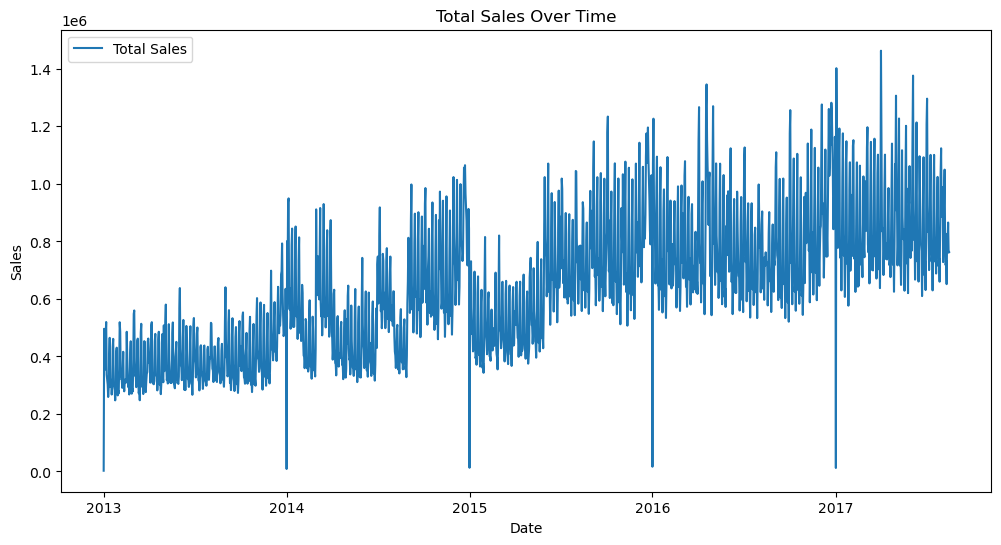

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())
print("\nMissing values in oil:\n", oil.isnull().sum())

total_sales = train.groupby('date')['sales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(total_sales.index, total_sales.values, label='Total Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [4]:
stores = stores.rename(columns={'type': 'store_type'})

train = train.merge(stores, on='store_nbr', how='left', suffixes=('_train', '_store'))
test = test.merge(stores, on='store_nbr', how='left', suffixes=('_test', '_store'))

print("Oil columns:", oil.columns)

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])

train = train.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
test = test.merge(oil[['date', 'dcoilwtico']], on='date', how='left')

print("Non-null dcoilwtico in train:", train['dcoilwtico'].notnull().sum())
print("Non-null dcoilwtico in test:", test['dcoilwtico'].notnull().sum())

train['dcoilwtico'] = train['dcoilwtico'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
test['dcoilwtico'] = test['dcoilwtico'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

print("Holidays columns:", holidays.columns)

holidays = holidays[holidays['transferred'] == False]

train = train.merge(holidays[['date', 'type']].rename(columns={'type': 'holiday_type'}), 
                    on='date', how='left')
test = test.merge(holidays[['date', 'type']].rename(columns={'type': 'holiday_type'}), 
                  on='date', how='left')

train['holiday'] = train['holiday_type'].notnull().astype(int)
test['holiday'] = test['holiday_type'].notnull().astype(int)

for df in [train, test]:
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_month'] = df['date'].dt.day
    df['is_month_end'] = (df['day_of_month'] >= 28).astype(int)  
    df['is_month_mid'] = (df['day_of_month'] == 15).astype(int)   
    df['post_earthquake'] = (df['date'] >= '2016-04-16').astype(int) 

categorical_columns = ['family', 'city', 'state', 'store_type', 'cluster', 'holiday_type']
for col in categorical_columns:
    if col in train.columns:  
        train[col] = train[col].astype('category').cat.codes
        test[col] = test[col].astype('category').cat.codes
    else:
        print(f"Column {col} not found in train or test data.")

print("\nTrain dtypes:\n", train.dtypes)
print("Test dtypes:\n", test.dtypes)

train = train.drop(['date', 'holiday_type'], axis=1, errors='ignore')
test = test.drop(['date', 'holiday_type'], axis=1, errors='ignore')

print("\nTrain columns after preprocessing:", train.columns)
print("Test columns after preprocessing:", test.columns)


Oil columns: Index(['date', 'dcoilwtico'], dtype='object')
Non-null dcoilwtico in train: 2072466
Non-null dcoilwtico in test: 21384
Holidays columns: Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

Train dtypes:
 id                          int64
date               datetime64[ns]
store_nbr                   int64
family                       int8
sales                     float64
onpromotion                 int64
city                         int8
state                        int8
store_type                   int8
cluster                      int8
dcoilwtico                float64
holiday_type                 int8
holiday                     int64
day_of_week                 int32
month                       int32
year                        int32
day_of_month                int32
is_month_end                int64
is_month_mid                int64
post_earthquake             int64
dtype: object
Test dtypes:
 id                          int

In [5]:
X = train.drop(['id', 'sales'], axis=1)
y = train['sales']
X_test = test.drop(['id'], axis=1)

missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

In [6]:
val_size = int(len(X) * 0.2)

X_train, X_val = X[:-val_size], X[-val_size:]
y_train, y_val = y[:-val_size], y[-val_size:]

In [7]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [10]:
def rmsle(y_true, y_pred):
    y_pred = np.clip(y_pred, 0, None)  
    return np.sqrt(mean_squared_log_error(y_true, y_pred))



# --------------------------
# BayesSearchCV (HPO on TRAIN ONLY)
# --------------------------

tscv = TimeSeriesSplit(n_splits=3)

rf = RandomForestRegressor(
    n_estimators=400,       # enough trees but not too slow
    max_depth=10,          # prevents overfitting
    min_samples_split=5,
    min_samples_leaf=3,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest on full training data...")
rf.fit(X_train, y_train)

Training Random Forest on full training data...


RandomForestRegressor(max_depth=10, max_features=0.8, min_samples_leaf=3,
                      min_samples_split=5, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [11]:
y_val_pred = rf.predict(X_val)

# Example metrics:

val_mse = rmsle(y_val, y_val_pred)

print("Validation RMSLE:", val_mse)


Validation RMSLE: 1.186987385842416


In [12]:
test_pred = rf.predict(X_test)

In [13]:
test_pred = np.clip(test_pred, 0, None)  

submission = pd.DataFrame({'id': test['id'], 'sales': test_pred})
submission.to_csv('rf_submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


In [75]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(
    max_depth=25,
    learning_rate=0.1,
    max_leaf_nodes=260,
    l2_regularization=3.0
)
model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=3.0, max_depth=25,
                              max_leaf_nodes=260)

In [76]:
y_val_pred = model.predict(X_val)

# Example metrics:

val_mse = rmsle(y_val, y_val_pred)

print("Validation RMSLE:", val_mse)

Validation RMSLE: 1.426238432117586


In [ ]:
test_pred = model.predict(X_test)
test_pred = np.clip(test_pred, 0, None)  

submission = pd.DataFrame({'id': test['id'], 'sales': test_pred})
submission.to_csv('rf_submission.csv', index=False)
print("Submission file created successfully!")

In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(1)   # single-step sales prediction
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),
    loss=tf.keras.losses.Huber(delta=1.0)  # smoother than MSE
)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=1024,  # large batch = faster training for big dataset
    callbacks=[es],
    verbose=1
)


Epoch 1/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 280.5823 - val_loss: 233277.7344
Epoch 2/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 244.5818 - val_loss: 1337.5126
Epoch 3/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 237.3195 - val_loss: 379.5268
Epoch 4/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 235.4981 - val_loss: 513.4624
Epoch 5/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 237.8264 - val_loss: 352.6165
Epoch 6/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 232.0499 - val_loss: 344.1371
Epoch 7/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 228.7982 - val_loss: 399.5368
Epoch 8/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 227.6153 - val_loss: 384.8230
Epoch 9/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 226.6722 - val_loss: 317.7127
Epoch 10/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 226.5477 - val_loss: 3679.9788
Epoch 11/20
2387/2387 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 

In [101]:
y_val_pred = model.predict(X_val)

# Example metrics:

val_mse = rmsle(y_val, y_val_pred)

print("Validation RMSLE:", val_mse)

19090/19090 ━━━━━━━━━━━━━━━━━━━━ 5s 262us/step
Validation RMSLE: 1.5630299226840878
